In [2]:
import random
import pickle
import os
import math
import time

class TicTacToeQLearning:
    def __init__(self, alpha=0.5, gamma=0.9, epsilon=0.1):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def get_state(self, board):
        return ''.join(board)

    def get_available_actions(self, board):
        return [i for i, x in enumerate(board) if x == ' ']

    def choose_action(self, board):
        state = self.get_state(board)
        actions = self.get_available_actions(board)
        if random.random() < self.epsilon:
            return random.choice(actions)
        q_values = [self.q_table.get((state, a), 0) for a in actions]
        max_q = max(q_values)
        best_actions = [a for a, q in zip(actions, q_values) if q == max_q]
        return random.choice(best_actions)

    def update_q_value(self, state, action, reward, next_state, done):
        key = (state, action)
        old_q = self.q_table.get(key, 0)
        future_q = 0 if done else max(
            [self.q_table.get((next_state, a), 0) for a in self.get_available_actions(list(next_state))], default=0)
        self.q_table[key] = old_q + self.alpha * (reward + self.gamma * future_q - old_q)

    def check_winner(self, board):
        win_states = [(0,1,2), (3,4,5), (6,7,8),
                      (0,3,6), (1,4,7), (2,5,8),
                      (0,4,8), (2,4,6)]
        for i, j, k in win_states:
            if board[i] == board[j] == board[k] and board[i] != ' ':
                return board[i]
        return None

    def play_game(self):
        board = [' '] * 9
        history = []
        player = 'X'
        while True:
            state = self.get_state(board)
            action = self.choose_action(board)
            board[action] = player
            next_state = self.get_state(board)
            winner = self.check_winner(board)
            done = winner or ' ' not in board

            if done:
                if winner == 'X':
                    reward_X, reward_O = 1, -1
                elif winner == 'O':
                    reward_X, reward_O = -1, 1
                else:
                    reward_X = reward_O = 0.5
            else:
                reward_X = reward_O = 0

            history.append((state, action, player, reward_X if player == 'X' else reward_O, next_state, done))
            if done:
                break
            player = 'O' if player == 'X' else 'X'

        for state, action, player, reward, next_state, done in reversed(history):
            self.update_q_value(state, action, reward, next_state, done)

    def save(self, filename):
        with open(filename, "wb") as f:
            pickle.dump(self.q_table, f)

    def train(self, max_episodes=10**4):
        training_times = []
        start_time = time.time()
        os.makedirs("models", exist_ok=True)
        powers = [10**i for i in range(1, 11)]  # [1, 10, 100, ..., 10^10]
        next_save = powers.pop(0)

        for i in range(1, max_episodes + 1):
            self.play_game()
            
            if i == next_save:
                training_times.append(time.time() - start_time)
                model_path = f"models/q_table_10_exp{int(math.log10(i))}.pkl"
                self.save(model_path)
                print(f"Saved model at episode {i}: {model_path} | Time taken: {training_times[-1]}")
                start_time = time.time()
                if powers:
                    next_save = powers.pop(0)

        return training_times

agent = TicTacToeQLearning()
training_times = agent.train(max_episodes=10**7)

training_times

Saved model at episode 10: models/q_table_10_exp1.pkl | Time taken: 0.001459360122680664
Saved model at episode 100: models/q_table_10_exp2.pkl | Time taken: 0.0037157535552978516
Saved model at episode 1000: models/q_table_10_exp3.pkl | Time taken: 0.035681724548339844
Saved model at episode 10000: models/q_table_10_exp4.pkl | Time taken: 0.3551604747772217
Saved model at episode 100000: models/q_table_10_exp5.pkl | Time taken: 3.3214941024780273
Saved model at episode 1000000: models/q_table_10_exp6.pkl | Time taken: 32.31264543533325
Saved model at episode 10000000: models/q_table_10_exp7.pkl | Time taken: 328.5272707939148


[0.001459360122680664,
 0.0037157535552978516,
 0.035681724548339844,
 0.3551604747772217,
 3.3214941024780273,
 32.31264543533325,
 328.5272707939148]

In [3]:
import pickle
import random

class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_action(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
        actions = [i for i, x in enumerate(state) if x == ' ']
        if not actions:
            return None

        if random.random() < epsilon:
            return random.choice(actions)

        q_values = [self.q_table.get((state, a), 0) for a in actions]
        max_q = max(q_values)
        max_actions = [a for a, q in zip(actions, q_values) if q == max_q]
        return random.choice(max_actions)

    def load(self, path):
        with open(path, 'rb') as f:
            self.q_table = pickle.load(f)

    def save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.q_table, f)


In [4]:
def evaluate_model(agent, games=1000, opponent_type="random"):
    win, loss, draw = 0, 0, 0

    for _ in range(games):
        board = [' '] * 9
        current_player = 'X'
        while True:
            if current_player == 'X':  # Agent's turn
                action = agent.choose_action(tuple(board), epsilon=0)  # Greedy
            else:  # Opponent's turn
                action = random.choice([i for i, x in enumerate(board) if x == ' '])
            
            if board[action] != ' ':
                continue
            board[action] = current_player

            winner = check_winner(board)
            if winner == 'X':
                win += 1
                break
            elif winner == 'O':
                loss += 1
                break
            elif ' ' not in board:
                draw += 1
                break

            current_player = 'O' if current_player == 'X' else 'X'
    
    return win / games, draw / games, loss / games


In [5]:
def simulate_game(agent, opponent, verbose=False):
    board = [' '] * 9
    state_action_pairs = []
    current_player = 'X'
    state = tuple(board)

    while True:
        if current_player == 'X':
            # Q-learning agent
            action = agent.get_action(state)
        else:
            # Opponent (e.g., Minimax)
            action = opponent.get_action(board[:])

        # Invalid move protection
        if board[action] != ' ':
            return 'O' if current_player == 'X' else 'X', state_action_pairs

        board[action] = current_player
        next_state = tuple(board)

        if verbose:
            print(f"\nPlayer {current_player} moves to position {action}")
            print_board(board)

        if current_player == 'X':
            state_action_pairs.append((state, action, next_state))

        winner = check_winner(board)
        if winner or ' ' not in board:
            if verbose:
                print(f"\nGame Over! Winner: {winner if winner else 'Draw'}")
            return winner, state_action_pairs

        state = next_state
        current_player = 'O' if current_player == 'X' else 'X'


In [6]:
def evaluate_agent(agent, opponent, num_games=100):
    results = {'win': 0, 'loss': 0, 'draw': 0}
    for _ in range(num_games):
        winner, _ = simulate_game(agent, opponent)
        if winner == 'X':
            results['win'] += 1
        elif winner == 'O':
            results['loss'] += 1
        else:
            results['draw'] += 1
    return results


In [7]:
def check_winner(board):
    win_states = [(0,1,2), (3,4,5), (6,7,8), 
                  (0,3,6), (1,4,7), (2,5,8), 
                  (0,4,8), (2,4,6)]
    for i, j, k in win_states:
        if board[i] == board[j] == board[k] and board[i] != " ":
            return board[i]
    return None


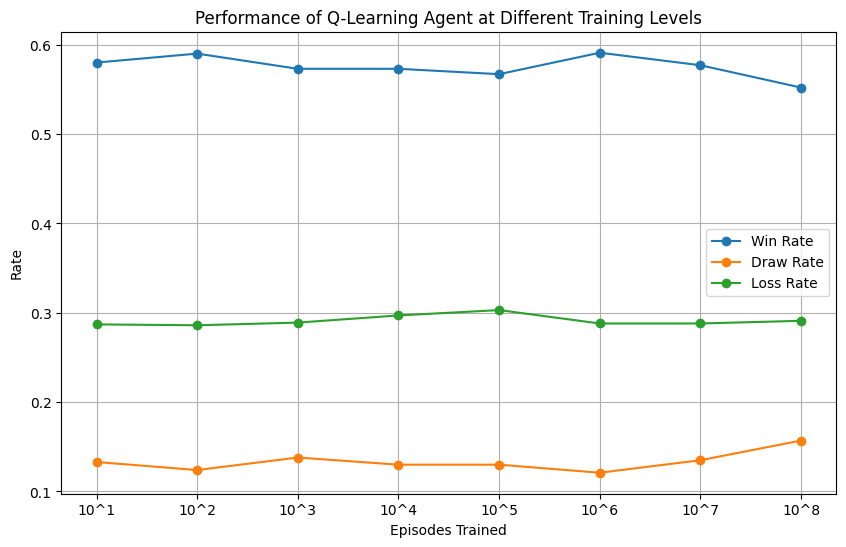

In [8]:
import matplotlib.pyplot as plt
import pickle
import os

model_paths = [f"models/q_table_10_exp{i}.pkl" for i in range(1, 9)]
labels = [f"10^{i}" for i in range(1, 9)]
wins, draws, losses = [], [], []

for path in model_paths:
    if os.path.exists(path):
        agent = QLearningAgent()
        agent.load(path)
        w, d, l = evaluate_model(agent)
        wins.append(w)
        draws.append(d)
        losses.append(l)
    else:
        print(f"Model not found: {path}")
        wins.append(0)
        draws.append(0)
        losses.append(0)

# Plotting
x = labels
plt.figure(figsize=(10, 6))
plt.plot(x, wins, label='Win Rate', marker='o')
plt.plot(x, draws, label='Draw Rate', marker='o')
plt.plot(x, losses, label='Loss Rate', marker='o')
plt.xlabel("Episodes Trained")
plt.ylabel("Rate")
plt.title("Performance of Q-Learning Agent at Different Training Levels")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
class MinimaxAgent:
    def choose_action(self, board):
        def minimax(board, is_max):
            winner = check_winner(board)
            if winner == 'O': return 1  # Minimax agent is 'O'
            if winner == 'X': return -1
            if ' ' not in board: return 0

            scores = []
            for i in range(9):
                if board[i] == ' ':
                    board[i] = 'O' if is_max else 'X'
                    score = minimax(board, not is_max)
                    board[i] = ' '
                    scores.append(score)
            return max(scores) if is_max else min(scores)

        best_score = -float('inf')
        best_move = None
        for i in range(9):
            if board[i] == ' ':
                board[i] = 'O'
                score = minimax(board, False)
                board[i] = ' '
                if score > best_score:
                    best_score = score
                    best_move = i
        return best_move

In [10]:
import random
import pickle
import time

def train_q_vs_minimax(episodes, save_path=None):
    q_agent = QLearningAgent(alpha=0.1, gamma=0.9, epsilon=0.2)
    minimax_agent = MinimaxAgent()

    start_time = time.time()
    for episode in range(1, episodes + 1):
        board = [' '] * 9
        state = tuple(board)
        current_player = 'X'  # Q-agent
        done = False

        while not done:
            if current_player == 'X':
                action = q_agent.choose_action(state)
            else:
                action = minimax_agent.choose_action(board)

            if board[action] != ' ':
                break  # invalid move

            board[action] = current_player
            next_state = tuple(board)
            winner = check_winner(board)

            if winner == 'X':
                reward = 1
                q_agent.q_table[(state, action)] = reward
                done = True
            elif winner == 'O':
                reward = -1
                q_agent.q_table[(state, action)] = reward
                done = True
            elif ' ' not in board:
                reward = 0.5
                q_agent.q_table[(state, action)] = reward
                done = True
            else:
                reward = 0
                next_best = max(
                    q_agent.q_table.get((next_state, a), 0)
                    for a in range(9) if next_state[a] == ' '
                )
                old_value = q_agent.q_table.get((state, action), 0)
                new_value = old_value + q_agent.alpha * (reward + q_agent.gamma * next_best - old_value)
                q_agent.q_table[(state, action)] = new_value
                state = next_state
                current_player = 'O' if current_player == 'X' else 'X'

        if episode % 100 == 0:
            training_time = (time.time() - start_time)
            # print(f"Episode {episode}")
            print(f"Saved model at episode {episode}| Time taken: {training_time}")
            start_time = time.time()

    if save_path:
        q_agent.save(save_path)


In [11]:
train_q_vs_minimax(10**3, save_path="models/q_vs_minimax.pkl")

Saved model at episode 100| Time taken: 6.495288372039795
Saved model at episode 200| Time taken: 6.488370180130005
Saved model at episode 300| Time taken: 6.484317779541016
Saved model at episode 400| Time taken: 6.493654489517212
Saved model at episode 500| Time taken: 6.4763898849487305
Saved model at episode 600| Time taken: 6.759257078170776
Saved model at episode 700| Time taken: 6.711238622665405
Saved model at episode 800| Time taken: 6.7115318775177
Saved model at episode 900| Time taken: 6.699806451797485
Saved model at episode 1000| Time taken: 6.703507900238037


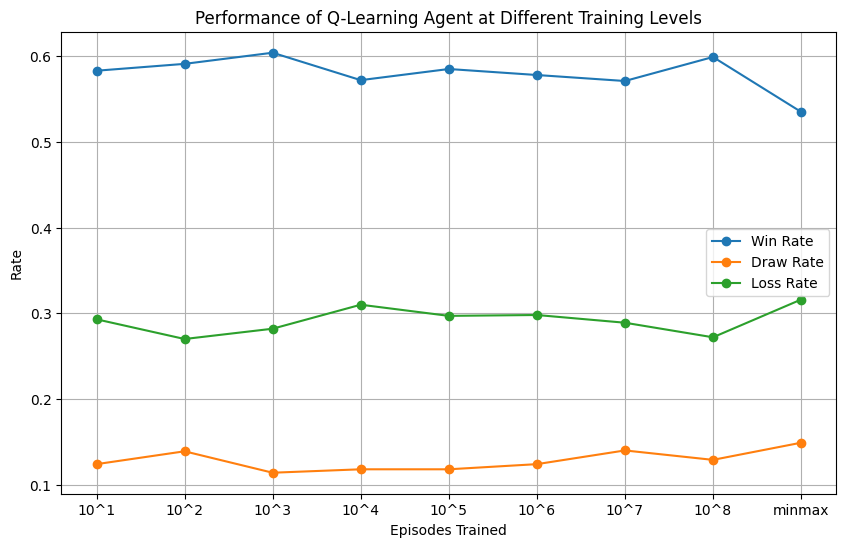

In [12]:
import matplotlib.pyplot as plt
import pickle
import os

model_paths = [f"models/q_table_10_exp{i}.pkl" for i in range(1, 9)]
model_paths.append("models/q_vs_minimax.pkl")
labels = [f"10^{i}" for i in range(1, 9)]
labels.append("minmax")
wins, draws, losses = [], [], []

for path in model_paths:
    if os.path.exists(path):
        agent = QLearningAgent()
        agent.load(path)
        w, d, l = evaluate_model(agent)
        wins.append(w)
        draws.append(d)
        losses.append(l)
    else:
        print(f"Model not found: {path}")
        wins.append(0)
        draws.append(0)
        losses.append(0)

# Plotting
x = labels
plt.figure(figsize=(10, 6))
plt.plot(x, wins, label='Win Rate', marker='o')
plt.plot(x, draws, label='Draw Rate', marker='o')
plt.plot(x, losses, label='Loss Rate', marker='o')
plt.xlabel("Episodes Trained")
plt.ylabel("Rate")
plt.title("Performance of Q-Learning Agent at Different Training Levels")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import tkinter as tk
from tkinter import messagebox
import random as rand

class HumanVsQAgent:
    def __init__(self, *, difficulty, agent):
        self.window = tk.Tk()
        self.window.title("Tic-Tac-Toe (Q Agent)")
        self.current_player = "X"  # Human
        self.board = [" "] * 9
        self.buttons = []
        self.agent = agent
        self.difficulty = difficulty  # ε value: probability to play randomly

        self.create_board()

    def create_board(self):
        for i in range(3):
            row = []
            for j in range(3):
                button = tk.Button(self.window, text=" ", font=("Arial", 24), width=5, height=2,
                                   command=lambda x=i, y=j: self.make_move(x, y))
                button.grid(row=i, column=j)
                row.append(button)
            self.buttons.append(row)

    def make_move(self, row, col):
        index = row * 3 + col
        if self.board[index] == " " and self.current_player == "X":
            self.board[index] = "X"
            self.buttons[row][col]["text"] = "X"

            winner = self.check_winner()
            if winner:
                messagebox.showinfo("Game Over", f"{winner} wins!")
                self.reset_game()
                return
            elif " " not in self.board:
                messagebox.showinfo("Game Over", "It's a Draw!")
                self.reset_game()
                return

            self.current_player = "O"
            self.q_agent_move()

    def q_agent_move(self):
        if rand.random() < self.difficulty:
            self.agent_move()  # Q-learning agent
        else:
            self.random_move()

    def agent_move(self):
        state = tuple(self.board)
        actions = [i for i in range(9) if self.board[i] == " "]
        if not actions:
            return
        q_values = [self.agent.q_table.get((state, a), 0) for a in actions]
        best_action = actions[q_values.index(max(q_values))]

        self.board[best_action] = "O"
        row, col = divmod(best_action, 3)
        self.buttons[row][col]["text"] = "O"

        winner = self.check_winner()
        if winner:
            messagebox.showinfo("Game Over", f"{winner} wins!")
            self.reset_game()
        elif " " not in self.board:
            messagebox.showinfo("Game Over", "It's a Draw!")
            self.reset_game()
        else:
            self.current_player = "X"

    def random_move(self):
        choices = [i for i in range(9) if self.board[i] == " "]
        move = rand.choice(choices)
        self.board[move] = "O"
        row, col = divmod(move, 3)
        self.buttons[row][col]["text"] = "O"

        winner = self.check_winner()
        if winner:
            messagebox.showinfo("Game Over", f"{winner} wins!")
            self.reset_game()
        elif " " not in self.board:
            messagebox.showinfo("Game Over", "It's a Draw!")
            self.reset_game()
        else:
            self.current_player = "X"

    def check_winner(self):
        win_states = [(0, 1, 2), (3, 4, 5), (6, 7, 8),
                      (0, 3, 6), (1, 4, 7), (2, 5, 8),
                      (0, 4, 8), (2, 4, 6)]
        for i, j, k in win_states:
            if self.board[i] == self.board[j] == self.board[k] and self.board[i] != " ":
                return self.board[i]
        return None

    def reset_game(self):
        self.board = [" "] * 9
        self.current_player = "X"
        for row in self.buttons:
            for button in row:
                button["text"] = " "

    def run(self):
        self.window.mainloop()


In [14]:
game = HumanVsQAgent(difficulty=0.5, agent=MinimaxAgent)
game.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Aditya\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Aditya\AppData\Local\Temp\ipykernel_5112\3567570543.py", line 22, in <lambda>
    command=lambda x=i, y=j: self.make_move(x, y))
                             ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Aditya\AppData\Local\Temp\ipykernel_5112\3567570543.py", line 44, in make_move
    self.q_agent_move()
  File "C:\Users\Aditya\AppData\Local\Temp\ipykernel_5112\3567570543.py", line 48, in q_agent_move
    self.agent_move()  # Q-learning agent
    ^^^^^^^^^^^^^^^^^
  File "C:\Users\Aditya\AppData\Local\Temp\ipykernel_5112\3567570543.py", line 57, in agent_move
    q_values = [self.agent.q_table.get((state, a), 0) for a in actions]
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Aditya\AppData\Local\Temp\ipy